# Monet style transfer with GAN on PyTorch

## 1. Set Up the Environment

Load the necessary libraries first:

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder


from PIL import Image
from typing import Tuple
import random
import os
import glob


from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
torch.__version__

'1.13.1+cpu'

### Creating the Dataset

In [3]:
monet = "C:/Users/Dennis/Documents/monet/"
photo = "C:/Users/Dennis/Documents/photo/"

In [4]:
# Define common image file extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tiff']

In [5]:
# Initialize count
image_count = 0

# Count images with each extension
for ext in image_extensions:
    image_count += len(glob.glob(os.path.join(monet, ext)))

print(f"Number of images: {image_count}")

Number of images: 300


In [6]:
# Initialize count
image_count = 0

# Count images with each extension
for ext in image_extensions:
    image_count += len(glob.glob(os.path.join(photo, ext)))

print(f"Number of images: {image_count}")

Number of images: 7038


### Print Images

In [7]:
# Function to get the first 5 random jpg files from a directory
def get_random_images(directory, num_images=5):
    # List all .jpg files in the directory
    images = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    
    # Shuffle the list of images randomly
    random.shuffle(images)
    
    # Select the first num_images files
    return images[:num_images]


In [8]:
# Get random images from both directories
monet_images = get_random_images(monet)
photo_images = get_random_images(photo)

In [9]:
# Print the selected images
print("Monet images:", monet_images)
print("Photo images:", photo_images)

Monet images: ['e9f686534b.jpg', '7952021d2f.jpg', '14162de938.jpg', '4f3f4ff590.jpg', 'fd63a333f1.jpg']
Photo images: ['cbca377969.jpg', 'f4c509ad69.jpg', '4bdbdcc1e5.jpg', '7659aebdef.jpg', '27b87e7785.jpg']


In [10]:
# Function to display images
def display_images(image_list, directory, title):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_list):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        plt.subplot(1, len(image_list), i + 1)
        plt.imshow(img)
        plt.title(f'{title} Image {i+1}')
        plt.axis('off')
    plt.show()

Displaying Monet images...


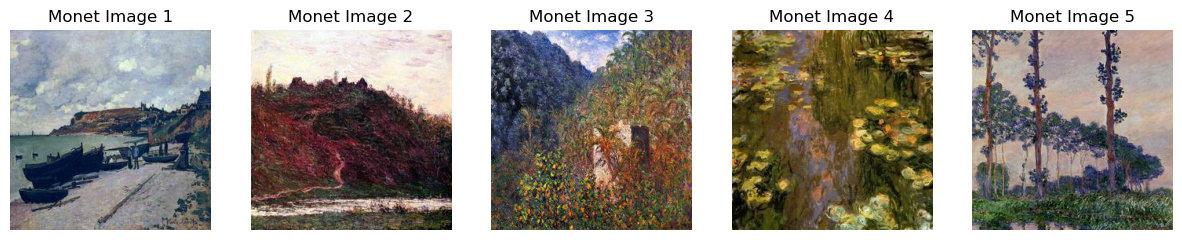

In [11]:
# Display the images
print("Displaying Monet images...")
display_images(monet_images, monet, "Monet")

Displaying Photo images...


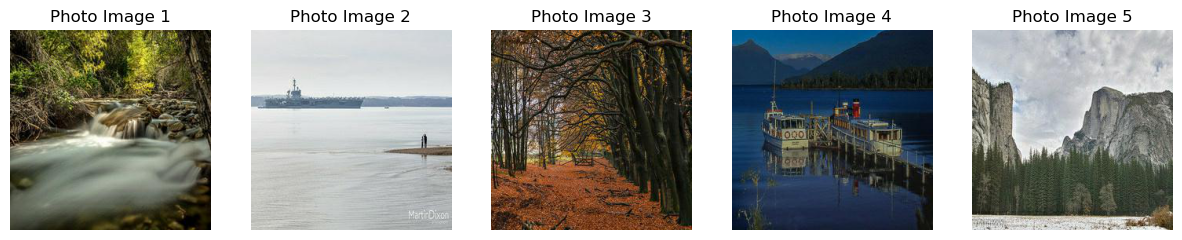

In [12]:
print("Displaying Photo images...")
display_images(photo_images, photo, "Photo")

### Suitable GAN Options for Monet GAN

#### 1. **CycleGAN (Image-to-Image Translation)**
   - **Use Case**: Translating images from one domain to another, e.g., transforming a normal `photo` into a `Monet`-like painting, or vice versa.
   - **Why Suitable**: 
     - Your dataset (300 Monet images and 7,038 photos) fits well with unpaired image-to-image translation, which CycleGAN excels at.
     - No need for paired training data, which aligns with your setup where Monet and photo images are unrelated.
   - **Recommended for**: Artistic style transfer and domain translation.
   
#### 2. **StyleGAN (for Generating Monet-like Paintings)**
   - **Use Case**: Generating high-quality Monet-style paintings from random noise vectors.
   - **Why Suitable**: 
     - **StyleGAN** is one of the state-of-the-art architectures for generating realistic images in a specific style.
     - Given your smaller Monet dataset, StyleGAN can focus on generating original Monet-like artwork.
   - **Recommended for**: Artistic generation, especially creating entirely new Monet-like paintings.

#### 3. **DCGAN (Deep Convolutional GAN)**
   - **Use Case**: Basic GAN architecture that works well for smaller datasets and is easier to implement.
   - **Why Suitable**: 
     - **DCGAN** is a great starting point for generating images, especially if you're on a CPU and don't have a massive dataset.
     - It's lighter than CycleGAN and StyleGAN, making it feasible for training on a CPU.
   - **Recommended for**: Beginners working with GANs, generating Monet-like images from random noise.

   
#### 4. **Pix2Pix (Paired Image Translation)**
   - **Use Case**: Paired image-to-image translation where input images have corresponding outputs.
   - **Why Suitable**:
     - If you can align `monet` images with `photo` images (even if approximate), you could use **Pix2Pix**.
   - **Recommended for**: Tasks like colorizing, translating between paired domains (not ideal here since your Monet and photo images are unpaired).
   
#### 5. **GAN for Image Augmentation**
   - **Use Case**: Generating additional Monet-style data to augment your dataset.
   - **Why Suitable**:
     - If the 300 Monet images are not enough, you can use a simple GAN to augment your dataset and generate more Monet-like images.
   - **Recommended for**: Dataset augmentation for further training.



# DCGAN Approach

## 2. Data Preparation

Preprocess the Monet images (since we only need to generate Monet-style images) and load them using PyTorch's DataLoader

In [13]:
# Define custom dataset
class MonetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure it's in RGB format
        if self.transform:
            image = self.transform(image)
        return image

In [14]:
# Define transforms for preprocessing images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [15]:
# Create the dataset and dataloader
monet_dir = "C:/Users/Dennis/Documents/monet/"
monet_dataset = MonetDataset(root_dir=monet_dir, transform=transform)
monet_loader = DataLoader(monet_dataset, batch_size=16, shuffle=True)

In [16]:
# Test DataLoader with smaller batch size
for images in monet_loader:
    print(images.shape)  # Should output something like [16, 3, 256, 256] if batch_size=16
    break  # Only test one batch



torch.Size([16, 3, 256, 256])


## 3. Define the Generator

The Generator takes random noise (latent vector) as input and outputs a generated image. The architecture for the generator will consist of transposed convolutions to upscale the noise vector into a 256x256x3 RGB image.

- Input: The generator starts with a latent vector (random noise), typically of size 100.
- Output: The final layer outputs a 256x256x3 image using a Tanh activation, ensuring pixel values range between [-1, 1].

In [17]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is a 256x256 RGB image
        )
    
    def forward(self, input):
        return self.main(input)


## 4. Define the Discriminator

The Discriminator is a binary classifier that distinguishes between real Monet images and the fake ones generated by the Generator.

- The discriminator outputs a single probability score that indicates whether the image is real or fake.

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Final layer: 1 output per image (kernel size 4, stride 1, no padding)
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output a probability for each image
        )
    
    def forward(self, input):
        return self.main(input).view(-1)  # Flatten the output to [batch_size]



## 5. Initialize and Train the DCGAN

Here’s the training loop to optimize both the generator and discriminator.

In [19]:
import torch.optim as optim

# Set device to CPU
device = torch.device("cpu")

# Initialize models on CPU
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function (Binary Cross Entropy Loss)
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 50
fixed_noise = torch.randn(64, 100, 1, 1, device=device)  # Fixed noise for generating images

for epoch in range(num_epochs):
    for i, data in enumerate(monet_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        real_images = data.to(device)  # Get real images from the loader and move to CPU
        real_labels = torch.ones(real_images.size(0), device=device)  # Real labels (all ones)
        fake_labels = torch.zeros(real_images.size(0), device=device)  # Fake labels (all zeros)
        
        # Train with real images
        output = netD(real_images).view(-1)  # Flatten the discriminator output
        lossD_real = criterion(output, real_labels)
        lossD_real.backward()

        # Train with fake images
        noise = torch.randn(real_images.size(0), 100, 1, 1, device=device)  # Random noise
        fake_images = netG(noise)  # Generate fake images from the generator
        output = netD(fake_images.detach()).view(-1)  # Flatten the output
        lossD_fake = criterion(output, fake_labels)
        lossD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output = netD(fake_images).view(-1)  # Discriminator evaluates fake images
        lossG = criterion(output, real_labels)  # Generator tries to fool the discriminator
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch}/{num_epochs}] Loss D: {lossD_real.item() + lossD_fake.item()}, Loss G: {lossG.item()}")


ValueError: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([2704])) is deprecated. Please ensure they have the same size.

In [ ]:
output = netD(real_images)
print("Discriminator output shape:", output.shape)  # Should be [batch_size]


In [ ]:
print("Output shape:", output.shape)  # This should be [batch_size]
print("Label shape:", real_labels.shape)  # This should also be [batch_size]
